In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
import itertools
from itertools import chain, combinations
from networkx.algorithms.flow import preflow_push
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.algorithms.flow import maximum_flow
from networkx.algorithms.flow import edmonds_karp
from networkx.algorithms.flow import dinitz
from networkx.algorithms.flow import boykov_kolmogorov
from collections import deque
from copy import copy
import warnings
import random
from timeit import default_timer as timer
inf = 10000000

## Defining class and fuctions:

In [21]:
class ADMG:
    def __init__(self):
        self.graph = nx.MultiDiGraph()
        self.costs = {}  # dictionary to store costs associated with each node
        self.name = None
    
    def add_node(self, node, cost):
        self.graph.add_node(node)
        self.costs[node] = cost
        
    def add_nodes(self, nodes_list, costs_list):
        for node in nodes_list:
            self.graph.add_node(node)
            self.costs[node] = costs_list[nodes_list.index(node)]
            
    def add_edges(self, edges_list):
        for edge in edges_list:
            self.graph.add_edge(edge[0], edge[1], bidirectional=edge[2])
            if edge[2]:  # if edge is bidirectional, add edge in opposite direction
                self.graph.add_edge(edge[1], edge[0], bidirectional=edge[2])
                
    def add_edges_costs(self, edges_list):
        for edge in edges_list:
            self.graph.add_edge(edge[0], edge[1], bidirectional=edge[2], cost=edge[3])
            if edge[2]: # if edge is bidirectional, add edge in opposite direction
                self.graph.add_edge(edge[1], edge[0], bidirectional=edge[2], cost=edge[3])
                
    def is_c_component(self, nodes):
        bidirected_edges = [edge for edge in self.graph.edges(nodes, data=True) if edge[2]['bidirectional']]
        bidirected_graph = nx.MultiDiGraph()
        bidirected_graph.add_edges_from(bidirected_edges)
        
        # Check if the graph formed by the bidirected edges is connected
        # We first need to convert to undirected graph for using the is_connected function
        bidirected_graph_undirected = bidirected_graph.to_undirected()
        return nx.is_connected(bidirected_graph_undirected)

    def find_max_c_component(self, S):
        while True:
            new_nodes = set()
            for node in S: 
                for edge in self.graph.edges(node, keys=True, data=True):
                    if ((edge[3]['bidirectional']) and (edge[1] not in S)):
                        new_nodes.add(edge[1])
            if not new_nodes:  # if no new nodes, we've found the max c-component
                return S
            else:
                S = S.union(new_nodes)

    def find_ancestors(self, node):
        ancestors = set()
        for edge in self.graph.in_edges(node, keys=True, data=True):
            if not edge[3]['bidirectional']:
                ancestors.add(edge[0])
                ancestors = ancestors.union(self.find_ancestors(edge[0]))
        # add the node itself to the ancestors
        ancestors.add(node)
        return ancestors
    
    def find_parents(self, node):
        parents = set()
        for edge in self.graph.in_edges(node, keys=True, data=True):
            if not edge[3]['bidirectional']:
                parents.add(edge[0])
        return parents
    
    def find_parents_in_subgraph(self, node, subgraph=None):
        if subgraph is None:
            subgraph = self.graph
        parents = set()
        for edge in subgraph.in_edges(node, data=True):
            if not edge[2]['bidirectional']:
                parents.add(edge[0])
        return parents

    def find_max_c_component_containing_S(self, F, S, subgraph=None):
        if subgraph is None:
            subgraph = self.graph

        # Extract the bidirected subgraph
        bidirected_subgraph = subgraph.edge_subgraph((u, v, k) for u, v, k, d in subgraph.edges(keys=True, data=True) if d.get('bidirectional', False))
        bidirected_subgraph_F = bidirected_subgraph.subgraph(F)  # Create a subgraph that only includes nodes in F

        bidirected_ADMG_F = ADMG()  # Create a new ADMG object for the subgraph
        bidirected_ADMG_F.graph = bidirected_subgraph_F  # Assign the subgraph to the new ADMG object

        max_c_component = set()
        for component in bidirected_ADMG_F.get_all_c_components():
            component_str = set(str(x) for x in component)
            if S.issubset(component_str):
                max_c_component = max_c_component.union(component)

        return max_c_component
    
    def find_max_c_component_of_split_S(self, F, S, subgraph=None): 
        if subgraph is None:
            subgraph = self.graph

        # Extract the bidirected subgraph
        bidirected_subgraph = subgraph.edge_subgraph((u, v, k) for u, v, k, d in subgraph.edges(keys=True, data=True) if d.get('bidirectional', False))
        bidirected_subgraph_F = bidirected_subgraph.subgraph(F)  # Create a subgraph that only includes nodes in F

        bidirected_ADMG_F = ADMG()  # Create a new ADMG object for the subgraph
        bidirected_ADMG_F.graph = bidirected_subgraph_F  # Assign the subgraph to the new ADMG object
        max_c_component = []
        S = list(S)
    
        for component in bidirected_ADMG_F.get_all_c_components():
            partition = []
            for i in range(len(S)):
                if S[i] in str(component):
                    partition.append(S[i])
            max_c_component.append(partition)

        return max_c_component
    
    def find_ancestors_in_subgraph(self, node, subgraph):
        ancestors = set()
        # Recursively find ancestors of the node
        def find_ancestors(current_node):
            for edge in subgraph.in_edges(current_node, data=True):
                if not edge[2]['bidirectional']:
                    ancestor = edge[0]
                    if ancestor not in ancestors:
                        ancestors.add(ancestor)
                        find_ancestors(ancestor)
        find_ancestors(node)
        # add the node itself to the ancestors
        ancestors.add(node)
        return ancestors

    def draw_graph(self):
        pos = nx.spring_layout(self.graph)
        nx.draw_networkx_nodes(self.graph, pos)

        # Separate edges by type
        directed_edges = [edge for edge in self.graph.edges(data=True) if not edge[2]['bidirectional']]
        bidirected_edges = [edge for edge in self.graph.edges(data=True) if edge[2]['bidirectional']]

        nx.draw_networkx_edges(self.graph, pos, edgelist=directed_edges, edge_color='black', connectionstyle='arc3, rad = 0')
        nx.draw_networkx_edges(self.graph, pos, edgelist=bidirected_edges, edge_color='purple', style='dashed', connectionstyle='arc3, rad = 0.1')
        nx.draw_networkx_labels(self.graph, pos)
        # add name of the graph
        plt.title(self.name)
        plt.show()

    def separate_graph(self):
        directed_edges = []
        bidirected_edges = []

        for edge in self.graph.edges(keys=True, data=True):
            if edge[3]['bidirectional']:
                bidirected_edges.append((edge[0], edge[1]))
            else:
                directed_edges.append((edge[0], edge[1]))

        directed_graph = ADMG()
        directed_graph.add_edges([(edge[0], edge[1], False) for edge in directed_edges])

        bidirected_graph = ADMG()
        bidirected_graph.add_edges([(edge[0], edge[1], True) for edge in bidirected_edges])

        return directed_graph, bidirected_graph

    def get_all_c_components(self):
        bidirected_graph = self.separate_graph()[1].graph  # Extract bidirected graph
        # Generate all c-components in the bidirected graph
        c_components = [component for component in nx.connected_components(bidirected_graph.to_undirected())]
        return c_components

    def P_Y_doX(self, Y, X):
        S = set()
        X_removed = self.delete_nodes(X)
        S = X_removed.find_ancestors(Y)
        # remove node Y from S
        S.remove(Y)
        return S
    
    def delete_nodes(self, nodes):
        G = self
        G.graph.remove_nodes_from(nodes)
        return G
    
    #---------------------------------------------------------------------------------------------------------------------------------------------------

    # MOST IMPORTANT FUCTIONS
    # HHULL FUNCTION

    def Hhull(self, S, subgraph=None):
        multiple = False
        if subgraph is None:
            subgraph = self.graph
        F = set(subgraph.nodes)  # Initialize F as the set of all nodes in the subgraph
        while True:
            F1 = self.find_max_c_component_containing_S(F, S, subgraph)  # Find maximal c-component in the subgraph that contains S 
            subgraph_F1 = subgraph.subgraph(F1)  # Create a subgraph that only includes nodes in F1
            F2 = set()
            for node in S:
                F2 = F2.union(self.find_ancestors_in_subgraph(node, subgraph_F1)) 
            if F2 != F: 
                F = F2
            else:
                return F
    
    # WEIGTHED MINIMUM HITTING SET 
    def minimum_weight_hitting_set(self, set_family): # brute force algorithm
        # Create the universal set (the union of all nodes in the graph)
        universal_set = set(self.graph.nodes)
    
        # Initialize the minimum weight hitting set as the universal set and its weight as infinity
        min_weight_hitting_set = universal_set
        min_weight = inf
    
        # Generate all possible subsets of the universal set
        for i in range(len(universal_set)):
            for subset in itertools.combinations(universal_set, i+1):
                subset = set(subset)  # Convert the subset to a set
            
                # Check if the subset is a hitting set
                # Check if for every set in the set family, there is at least one element in common with the subset.
                if all(any(element in subset for element in s) for s in set_family):
                    # Calculate the weight of the subset
                    weight = sum(self.costs[element] for element in subset)
                
                    # If the subset is a hitting set and its weight is smaller than the current minimum weight, update the minimum hitting set and its weight
                    if weight < min_weight:
                        min_weight_hitting_set = subset
                        min_weight = weight
                    
        return min_weight_hitting_set
    
    # EXACT ALGORITHM  
    def min_cost_intervention(self, S): #assuming all costs are non-negative
        F = set()
        H = self.Hhull(S)
        if H == S:
            return set(), 0
        
        total_cost = 0  # Initialize the total cost of the intervention
        while True:
            while True:
                a = min(H - S, key=self.costs.get)
                new_H = self.Hhull(S, self.graph.subgraph(H - {a}))
                if new_H == S:
                    F.add(frozenset(H))  #immutable set
                    break
                else:
                    H = new_H
            A = self.minimum_weight_hitting_set([f - S for f in F])
            new_H = self.Hhull(S, self.graph.subgraph(set(self.graph.nodes) - A))
            total_cost += sum(self.costs[node] for node in A) 
            if new_H == S:
                return A, total_cost
            else:
                H = new_H 
                total_cost = 0
        
    # HEURISTIC ALGORITHM 
    def minimum_weighted_vertex_cut(self, S):
        # Step 1: Build the undirected graph H with vertices H ∪ {x, y}
        H_nodes = list(self.Hhull(S)) 

        H = self.__class__()                # Create a new instance of the class
        H_costs = list({node: self.costs[node] for node in H_nodes}.values())
        H.add_nodes(H_nodes,H_costs)        # Add nodes from H_nodes
        H.add_nodes(['x', 'y'],[0,0])       # Add auxiliary nodes 'x' and 'y'
        
        # Step 2: Connect v1 and v2 in H if they are connected with a bidirected edge in G
        for v1 in H_nodes:
            for v2 in H_nodes:
                if v1 != v2 and (v2 in self.graph[v1]) and any(self.graph[v1][v2][k]['bidirectional'] for k in self.graph[v1][v2]):
                    H.add_edges([(v1, v2, False)])
        
        # Step 3: Connect 'x' to vertices in pa(S) ∩ H and 'y' to vertices in S
        pa_S = set()
        for node in S:
            subgraph_pa = self.graph.subgraph(H.graph.nodes) # get subgraph H of G to find parents of node in H (with proper directionality)
            pa_S.update(self.find_parents_in_subgraph(node, subgraph_pa)) 
        tuples_x = [('x', node, False) for node in pa_S.intersection(H.graph.nodes)]    #to have x_out
        tuples_y = [('y', node, False) for node in S]                                   #to have y_in ---> identify a vertex cut for x − y 
        H.add_edges(tuples_x)
        H.add_edges(tuples_y)
        H.graph = H.graph.to_undirected() # make H undirected and remove duplicate edges
        
        # Step 4: Convert minimum-weight vertex cut to minimum-weight edge cut
        G_prime = nx.DiGraph()

        for node in S:
            self.costs[node] = float('inf')
        self.costs['y'] = 0
        self.costs['x'] = 0
        
        H_dir = H.graph.to_directed() 
        
        for u in H_dir.nodes(data=False):
            G_prime.add_edge(u+'_in', u+'_out', weight= self.costs[u]) 
            
        # if directed edge goes into u in H, connect it to u+'_in' in G_prime
        for n in H_dir.nodes(data=False):
            for s in H_dir.successors(n):
                G_prime.add_edge(n+'_out', s+'_in', weight=float('inf'))
            for p in H_dir.predecessors(n):
                G_prime.add_edge(p+'_out', n+'_in', weight=float('inf'))
        
        # merge nodes x_in and x_out into x
        G_prime = nx.contracted_nodes(G_prime, 'x_out', 'x_in', self_loops=False, copy=False)
        # merge nodes y_in and y_out into y
        G_prime = nx.contracted_nodes(G_prime, 'y_in', 'y_out', self_loops=False, copy=False)
        
        # Step 5: Solve the minimum-weight edge cut problem (using a shortest augmenting path algorithm)
        cut_value, partition = nx.minimum_cut(G_prime, 'x_out', 'y_in', capacity='weight', flow_func=preflow_push)
        reachable, non_reachable = partition

        cutset = set() 
        for u, r in ((n, G_prime[n]) for n in reachable):
            cutset.update((u, v) for v in r if v in non_reachable)

        # Step 6: Convert the minimum-weight edge cut back to the minimum-weight vertex cut
        vertex_cut = set()
        for node in cutset:
            if ('out' in node[0] or 'out' in node[1]):
                vertex_cut.add(node[0].split('_')[0])

        cut_cost = sum(self.costs[node] for node in vertex_cut)

        return vertex_cut, cut_cost
    
    def minimum_weighted_vertex_cut_2(self, S): # uses vertex cut which may be more complex than edge cut
        # Step 1: Build the undirected graph H with vertices H ∪ {x, y}
        H_nodes = list(self.Hhull(S)) 
        H = self.__class__()                # Create a new instance of the class
        H_costs = list({node: self.costs[node] for node in H_nodes}.values())
        H.add_nodes(H_nodes,H_costs)        # Add nodes from H_nodes
        H.add_nodes(['x', 'y'],[0,0])       # Add auxiliary nodes 'x' and 'y'
        
        # Step 2: Connect v1 and v2 in H if they are connected with a bidirected edge in G
        for v1 in H_nodes:
            for v2 in H_nodes:
                if v1 != v2 and (v2 in self.graph[v1]) and any(self.graph[v1][v2][k]['bidirectional'] for k in self.graph[v1][v2]):
                    H.add_edges([(v1, v2, False)])
        
        # Step 3: Connect 'x' to vertices in pa(S) ∩ H and 'y' to vertices in S
        pa_S = set()
        for node in S:
            subgraph_pa = self.graph.subgraph(H.graph.nodes) # get subgraph H of G to find parents of node in H (with proper directionality)
            pa_S.update(self.find_parents_in_subgraph(node), subgraph_pa)
        tuples_x = [('x', node, False) for node in pa_S.intersection(H.graph.nodes)]    #to have x_out
        tuples_y = [('y', node, False) for node in S]                                   #to have y_in ---> identify a vertex cut for x − y 
        H.add_edges(tuples_x)
        H.add_edges(tuples_y)
        H.graph = H.graph.to_undirected() # make H undirected and remove duplicate edges
        
        # Step 4: Convert minimum-weight vertex cut to minimum-weight edge cut
        G_prime = nx.DiGraph()
        H.draw_graph()
        for node in S:
            self.costs[node] = inf
        self.costs['y'] = 0
        self.costs['x'] = 0
        
        H.costs = {node: self.costs[node] for node in H.graph.nodes}
        
        cuts = nx.articulation_points(H.graph)
        current_cost = inf
        for i in cuts:
            if self.costs[i] < current_cost:
                current_cost = self.costs[i]
                vertex_cut = i

        cut_cost = sum(self.costs[node] for node in vertex_cut)

        return vertex_cut, cut_cost
    
    def extract_directed_subgraph(self):
        directed_subgraph = self.graph.copy()
        undirected_edges = [(u, v) for u, v, attrs in self.graph.edges(data=True) if attrs.get('bidirectional')]
        directed_subgraph.remove_edges_from(undirected_edges)
        return directed_subgraph
    
    # EXACT ALGORITHM ADJUSTED FOR DISCONNECTED C-COMP
    def min_cost_intervention_splitsetS(self, S): # assuming all costs are non-negative #heuristic, for S with more than one connected component
        A = []
        min_cost = 0
        # Partition S into subsets S(1), ..., S(t)
        c_comps = self.find_max_c_component_of_split_S(self.graph, S)
        
        # transform c_comps into a list of sets
        c_comps = [set(c) for c in c_comps]
        for comp in c_comps:
            A_p, cost_p = self.min_cost_intervention(comp)
            if A_p != set():
                A_p = A_p.difference(*A)
                if A_p == set():
                    cost_p=0
                if A_p != set():
                    cost_p=0
                    A.append(A_p)
                    for node in A_p:
                        cost_p += self.costs[str(node)]
                min_cost += cost_p
        return A, min_cost

    # HEURISTIC ALGORITHM ADJUSTED FOR DISCONNECTED C-COMP
    def minimum_weighted_vertex_cut_splitsetS(self, S):
        # Step 1: Build the undirected graph H with vertices H ∪ {x, y}
        bidirected_subgraph = self.graph.edge_subgraph((u, v, k) for u, v, k, d in self.graph.edges(keys=True, data=True) if d.get('bidirectional', False))
        comps = [set(s) for s in nx.connected_components(bidirected_subgraph.to_undirected())]
        comps = [c for c in comps if c.intersection(S) != set()]
        total_cost = 0
        vertex_cut_set = set()
        
        for comp in comps:
            # extract the vertices of the component that are in S
            S_nodes = comp.intersection(S)
            H_nodes = list(self.Hhull(S_nodes)) 
            H = self.__class__()                # Create a new instance of the class
            H_costs = list({node: self.costs[node] for node in H_nodes}.values())
            H.add_nodes(H_nodes,H_costs)        # Add nodes from H_nodes
            H.add_nodes(['x', 'y'],[0,0])       # Add auxiliary nodes 'x' and 'y'
            
            # Step 2: Connect v1 and v2 in H if they are connected with a bidirected edge in G
            for v1 in H_nodes:
                for v2 in H_nodes:
                    if v1 != v2 and (v2 in self.graph[v1]) and any(self.graph[v1][v2][k]['bidirectional'] for k in self.graph[v1][v2]):
                        H.add_edges([(v1, v2, False)])
            
            # Step 3: Connect 'x' to vertices in pa(S) ∩ H and 'y' to vertices in S
            pa_S = set()
            for node in S_nodes:
                pa_S.update(self.find_parents(node))
                # remove nodes that are in S
                pa_S.difference_update(S_nodes)
            tuples_x = [('x', node, False) for node in pa_S.intersection(H.graph.nodes)]    #to have x_out
            tuples_y = [(node, 'y', False) for node in S_nodes]                             #to have y_in ---> identify a vertex cut for x − y 
            if tuples_x == [] or tuples_y == []: 
                return set(), -1
            H.add_edges(tuples_x)
            H.add_edges(tuples_y)
            H.graph = H.graph.to_undirected() # make H undirected and remove duplicate edges
            # Step 4: Convert minimum-weight vertex cut to minimum-weight edge cut
            G_prime = nx.DiGraph()
          
            for node in S_nodes:
                self.costs[node] = inf
            self.costs['y'] = 0
            self.costs['x'] = 0
            # get directed subgraph of self
            directed_subgraph = self.extract_directed_subgraph()
            
            for u in directed_subgraph.nodes(data=False):
                G_prime.add_edge(u+'_in', u+'_out', weight= self.costs[u]) 
                
            # if directed edge goes into u in H, connect it to u+'_in' in G_prime
            for n in directed_subgraph.nodes(data=False):
                for s in directed_subgraph.successors(n):
                    G_prime.add_edge(n+'_out', s+'_in', weight=inf)
                for p in directed_subgraph.predecessors(n):
                    G_prime.add_edge(p+'_out', n+'_in', weight=inf)
                    
                    
            for source in tuples_x:
                G_prime.add_edge('x_out', source[1]+'_in',weight=inf)
            for sink in tuples_y:
                G_prime.add_edge(sink[0]+'_out','y_in', weight=inf)
            
            # Step 5: Solve the minimum-weight edge cut problem (using a shortest augmenting path algorithm)
            cut_value, partition = nx.minimum_cut(G_prime, 'x_out', 'y_in', capacity='weight', flow_func=edmonds_karp)
            reachable, non_reachable = partition

            cutset = set() 
            for u, r in ((n, G_prime[n]) for n in reachable):
                cutset.update((u, v) for v in r if v in non_reachable)

            # Step 6: Convert the minimum-weight edge cut back to the minimum-weight vertex cut
            vertex_cut = set()
            for node in cutset:
                if ('out' in node[0] or 'out' in node[1]):
                    vertex_cut.add(node[0].split('_')[0])

            cut_cost = sum(self.costs[node] for node in vertex_cut)
            total_cost += cut_cost
            vertex_cut_set.update(vertex_cut)
            if total_cost >= inf:
                total_cost = inf
                vertex_cut_set = set()

        return vertex_cut_set, total_cost

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def generate_partitions(S):
    if len(S) == 1:
        yield [ S ]
        return
    
    S = list(S)
    first = S[0] 
    for smaller in generate_partitions(S[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller

## Example 1 

In [3]:
G = ADMG()
G.name = "G"
edge_list = [("v1","v2",False),("v1","t",True), 
             ("v2","s2",True), ("v2","s1",False),
             ("v3","t", True), ("v3","t",False),
             ("s1","v3",False),("s1","s2",False), ("s1","t",True),
             ("s2","t", False)]
G.add_node('v1',1)
G.add_node('v2',1)
G.add_node('v3',1)
G.add_node('s1',1)
G.add_node('s2',1)
G.add_node('t', 1)
G.add_edges(edge_list)
G.min_cost_intervention_splitsetS({'t','v3','s2','v2'})

([{'s1'}], 1)

## Toy example

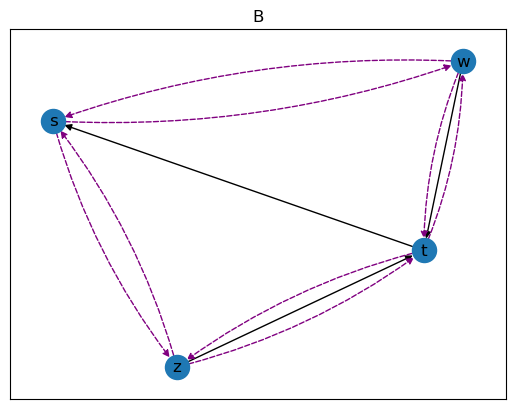

minimum cost intervention output:  ({'t'}, 3)
mimimum vertex cut output:  ({'t'}, 3)
minimum cost intervention split set S output:  ([{'t'}], 3)
minimum vertex cut split set S output:  ({'t'}, 3)


In [4]:
B = ADMG()
B.name = "B"
edge_list_B = [("s","z",True),("s","w",True),
            ("t","s",False), ("t","z",True), ("t","w",True),
            ("w","t",False),
            ("z","t",False)]
B.add_edges(edge_list_B)
B.add_node('s',0)
B.add_node('t',3)
B.add_node('z',2)
B.add_node('w',2)
B.draw_graph()
print("minimum cost intervention output: ", B.min_cost_intervention({'s'}))
print("mimimum vertex cut output: ", B.minimum_weighted_vertex_cut({'s'}))
print("minimum cost intervention split set S output: ", B.min_cost_intervention_splitsetS({'s'}))
print("minimum vertex cut split set S output: ", B.minimum_weighted_vertex_cut_splitsetS({'s'}))

## Example 2

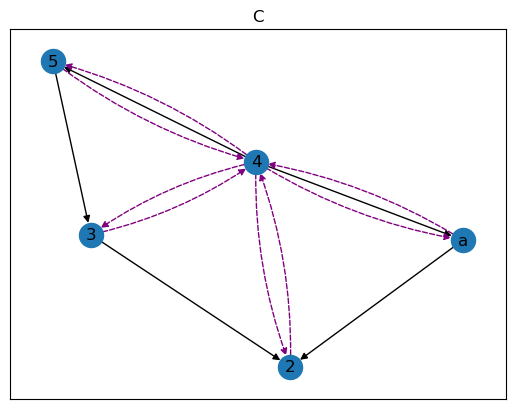

minimum cost intervention output:  ({'4'}, 5)
mimimum vertex cut output:  ({'4'}, 5)
minimum cost intervention output split set S output:  ([{'4'}], 5)


In [5]:
C = ADMG()
C.name = "C"
edge_list_C = [ ('a', '2', False), ('3', '2', False), ('4', 'a', False),
                ('5', '3', False), ('4', '5', False),
                ('a', '4',True), ('5', '4', True), ('4', '2',True),
                ('4', '3',True)]
C.add_edges(edge_list_C)
C.add_node('a',5)
C.add_node('2',4)
C.add_node('3',3)
C.add_node('4',5)
C.add_node('5',1)
C.draw_graph()
Y_c = {'2'}
print("minimum cost intervention output: ", C.min_cost_intervention(Y_c))
print("mimimum vertex cut output: ", C.minimum_weighted_vertex_cut(Y_c))
print("minimum cost intervention output split set S output: ", C.min_cost_intervention_splitsetS(Y_c))

## Example 3

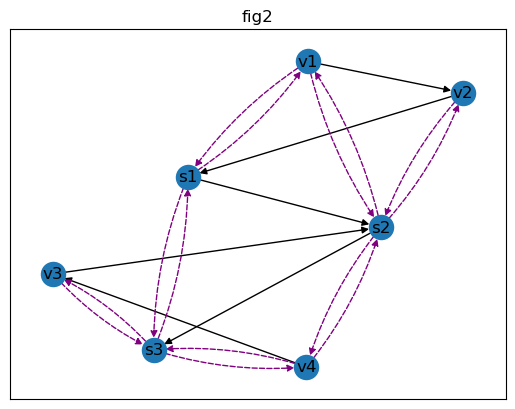

mimimum cost invervention split S output:  ([{'s1'}], 1)
minimum vertex cut split set S output:  ({'s1'}, 1)


In [6]:
fig2 = ADMG()
fig2.name = "fig2"
edge_list_fig2 = [("s1","s2",False),("s1","s3",True),("s1","v1",True),
                  ("s2","s3",False),("s2","v1",True),("s2","v2",True), ("s2","v4",True),
                  ("s3","v3",True),("s3","v4",True),
                  ("v1","v2",False),
                  ("v2","s1",False),
                  ("v3","s2",False), 
                  ("v4","v3",False)]
fig2.add_edges(edge_list_fig2)
fig2.add_node('s1',1)
fig2.add_node('s2',1)
fig2.add_node('s3',1)
fig2.add_node('v1',5)
fig2.add_node('v2',5)
fig2.add_node('v3',5)
fig2.add_node('v4',5)
fig2.draw_graph()
print("mimimum cost invervention split S output: ", fig2.min_cost_intervention_splitsetS({'s2'}))
print("minimum vertex cut split set S output: ", fig2.minimum_weighted_vertex_cut_splitsetS({'s2'}))

## GeneratING random ADMGs with Erdos–Rényi model

## Loop where the exact and the heuristic algorithm take as input one random node

In [15]:
time_algorithm1 = []
time_heuristic_algorithm = []
set_algorithm1 = []
cost_algorithm1 = []
set_heuristic_algorithm = []
cost_heuristic_algorithm = []
different_output = []

for i in np.arange(100):
    H_erdos_renyi = nx.erdos_renyi_graph(20, 0.1, seed=42, directed=True)

    # transform to ADMG
    test = ADMG()
    test.name = "test"
    edge_list_test = []
    list_of_nodes = list(H_erdos_renyi.nodes)
      
    # transform into list of strings
    list_of_nodes = [str(i) for i in list_of_nodes]
    list_of_edges = list(H_erdos_renyi.edges)

    # transform into list of strings
    list_of_edges = [(str(i), str(j)) for i,j in list_of_edges]
    to_remove = []
    to_add = []
    for i in list_of_edges:
        rand2 = random.randint(0,10) # random number between 0 and 1 which will be used to decide whether edge is bidirected or not 
        if rand2 > 7:
            # bidirected edge
            edge_list_test.append((i[0], i[1], True))
        if rand2 <= 7:
            # directed edge
            edge_list_test.append((i[0], i[1], False))

    for i in list_of_edges:
        if (i[1], i[0], 0) not in list_of_edges:
            edge_list_test.append((i[0], i[1], False)) 
        if (i[1], i[0], 0) in edge_list_test:
            to_remove.append((i[1], i[0], False))
            to_add.append((i[0], i[1], True))

    for r in to_remove:           
        edge_list_test.remove(r)
    for a in to_add:
        edge_list_test.append(a)

    test.add_edges(edge_list_test)

    for i in list_of_nodes: 
        test.add_node(i, random.randint(1, 5))
    
    test_variable = True 
    
    while test_variable: 
        S = random.sample(list_of_nodes, random.randint(1, 1))  # random lenght of random set of nodes 
        start_heuristic_algorithm = timer()
        set2,cost2 = test.minimum_weighted_vertex_cut_splitsetS(S)
        end_heuristic_algorithm = timer()
        if not cost2<0 and cost2 != inf:
            test_variable = False 
            start_algorithm1 = timer()
            set1,cost1 = test.min_cost_intervention_splitsetS(S)
            end_algorithm1 = timer()
            time_algorithm1 = time_algorithm1 + [end_algorithm1-start_algorithm1]
            set_algorithm1 = set_algorithm1 + [set1]
            cost_algorithm1 = cost_algorithm1 + [cost1]
            time_heuristic_algorithm = time_heuristic_algorithm + [end_heuristic_algorithm-start_heuristic_algorithm]
            set_heuristic_algorithm = set_heuristic_algorithm + [set2]
            cost_heuristic_algorithm = cost_heuristic_algorithm + [cost2]


Plot of time (in seconds) and cost both for the exact and the heuristic algorithm 


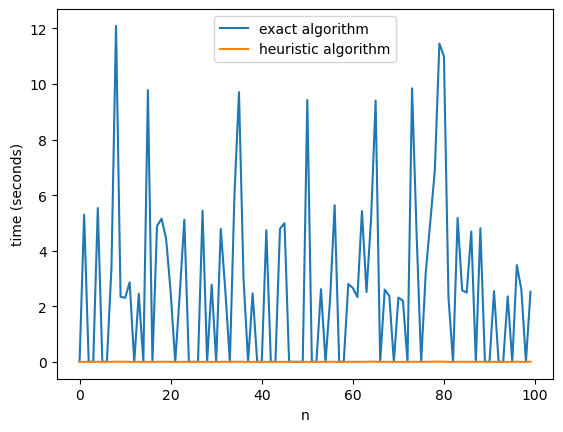

In [16]:
# time 
plt.plot(time_algorithm1, label='exact algorithm')
plt.plot(time_heuristic_algorithm, label='heuristic algorithm')
plt.legend()
plt.xlabel("n")
plt.ylabel("time (seconds)")
plt.show()

In [17]:
time_heuristic_algorithm

[0.0010864000000765373,
 0.003716299999950934,
 0.0006918000001405744,
 0.0007927999999992608,
 0.008586500000092201,
 0.0011982999999418098,
 0.0007906000000730273,
 0.005062299999963216,
 0.01033400000005713,
 0.002796299999999974,
 0.007882400000198686,
 0.003502299999809111,
 0.0007203000000117754,
 0.004747899999983929,
 0.0011689999998907297,
 0.005242899999984729,
 0.0005761999998412648,
 0.006638399999928879,
 0.004406799999969735,
 0.007599000000027445,
 0.004093000000011671,
 0.00031790000002729357,
 0.003620400000045265,
 0.004428599999982907,
 0.00043819999996230763,
 0.0009196000000883942,
 0.00032289999990098295,
 0.0031701000000339263,
 0.0009442999999009771,
 0.002452899999980218,
 0.0008245999999871856,
 0.00507789999983288,
 0.004237200000034136,
 0.0007324000000608066,
 0.006669800000054238,
 0.007758400000057009,
 0.005919100000028266,
 0.0006428000001506007,
 0.0025164999999560678,
 0.0004939999998896383,
 0.0009012000000439002,
 0.005539799999951356,
 0.0004936000

In [18]:
time_algorithm1

[0.004262000000153421,
 5.299374699999817,
 0.006932800000186035,
 0.007561699999996563,
 5.535787699999901,
 0.006277100000033897,
 0.006292499999972279,
 3.391110499999968,
 12.091487000000143,
 2.3419441999999435,
 2.3087743999999475,
 2.8636260999999195,
 0.0047790000000986765,
 2.4541262999998708,
 0.013018999999985681,
 9.778537499999857,
 0.0023323999998865474,
 4.891509100000121,
 5.156686000000036,
 4.436079699999937,
 2.510694600000079,
 0.001767799999925046,
 2.4602532000001247,
 5.115694000000076,
 0.0023373999999876105,
 0.0033252000000629778,
 0.0029455999999754567,
 5.440883499999927,
 0.005892099999982747,
 2.7785661999998865,
 0.006497300000091855,
 4.78723210000021,
 2.565099200000077,
 0.007367899999962901,
 5.989681799999971,
 9.707186800000045,
 2.985941000000139,
 0.00408900000002177,
 2.467838100000108,
 0.003963199999816425,
 0.0064561000001504,
 4.73896139999988,
 0.0032332000000678818,
 0.003977299999860406,
 4.795448700000179,
 4.991835000000037,
 0.006539799

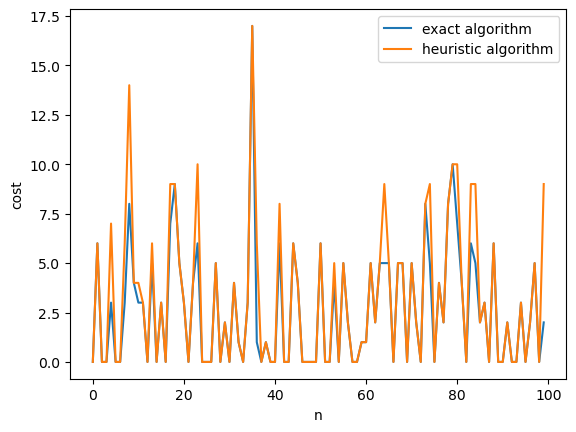

In [19]:
# cost
plt.plot(cost_algorithm1, label='exact algorithm')
plt.plot(cost_heuristic_algorithm, label='heuristic algorithm')
plt.legend()
plt.xlabel("n")
plt.ylabel("cost")
plt.show()

## Loop where the exact and the heuristic algorithm take as input at most 4 random nodes

In [22]:
time_algorithm1 = []
time_heuristic_algorithm = []
set_algorithm1 = []
cost_algorithm1 = []
set_heuristic_algorithm = []
cost_heuristic_algorithm = []
different_output = []

for i in np.arange(100):
    H_erdos_renyi = nx.erdos_renyi_graph(20, 0.1, seed=42, directed=True)

    # transform to ADMG
    test = ADMG()
    test.name = "test"
    edge_list_test = []
    list_of_nodes = list(H_erdos_renyi.nodes)
      
    # transform into list of strings
    list_of_nodes = [str(i) for i in list_of_nodes]
    list_of_edges = list(H_erdos_renyi.edges)

    # transform into list of strings
    list_of_edges = [(str(i), str(j)) for i,j in list_of_edges]
    to_remove = []
    to_add = []
    for i in list_of_edges:
        rand2 = random.randint(0,10) # random number between 0 and 1 which will be used to decide whether edge is bidirected or not 
        if rand2 > 7:
            # bidirected edge
            edge_list_test.append((i[0], i[1], True))
        if rand2 <= 7:
            # directed edge
            edge_list_test.append((i[0], i[1], False))

    for i in list_of_edges:
        if (i[1], i[0], 0) not in list_of_edges:
            edge_list_test.append((i[0], i[1], False)) 
        if (i[1], i[0], 0) in edge_list_test:
            to_remove.append((i[1], i[0], False))
            to_add.append((i[0], i[1], True))
            
    for r in to_remove:           
        edge_list_test.remove(r)
    for a in to_add:
        edge_list_test.append(a)

    test.add_edges(edge_list_test)

    for i in list_of_nodes: 
        test.add_node(i, random.randint(1, 5))
    
    test_variable = True 
    
    while test_variable: 
        S = random.sample(list_of_nodes, random.randint(1, 4))  # random lenght of random set of nodes 
        start_heuristic_algorithm = timer()
        set2,cost2 = test.minimum_weighted_vertex_cut_splitsetS(S)
        end_heuristic_algorithm = timer()
        if not cost2<0 and cost2 != inf:
            test_variable = False 
            start_algorithm1 = timer()
            set1,cost1 = test.min_cost_intervention_splitsetS(S)
            end_algorithm1 = timer()
            time_algorithm1 = time_algorithm1 + [end_algorithm1-start_algorithm1]
            set_algorithm1 = set_algorithm1 + [set1]
            cost_algorithm1 = cost_algorithm1 + [cost1]
            time_heuristic_algorithm = time_heuristic_algorithm + [end_heuristic_algorithm-start_heuristic_algorithm]
            set_heuristic_algorithm = set_heuristic_algorithm + [set2]
            cost_heuristic_algorithm = cost_heuristic_algorithm + [cost2]


Plot of time (in seconds) and cost both for the exact and the heuristic algorithm 


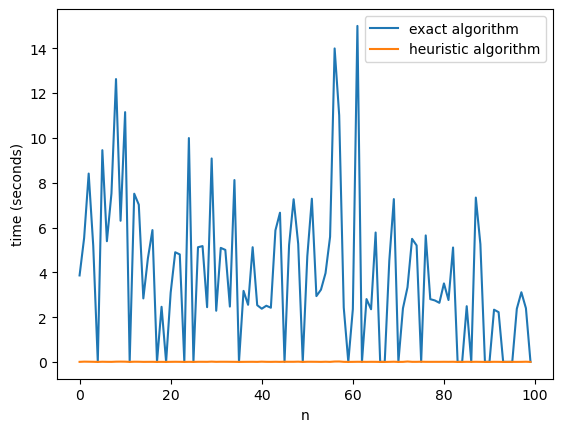

In [23]:
# time 
plt.plot(time_algorithm1, label='exact algorithm')
plt.plot(time_heuristic_algorithm, label='heuristic algorithm')
plt.legend()
plt.xlabel("n")
plt.ylabel("time (seconds)")
plt.show()

In [24]:
time_algorithm1

[3.86143560000005,
 5.533440400000018,
 8.408680900000036,
 5.188146599999982,
 0.0023962000000210537,
 9.453363500000023,
 5.388933500000121,
 7.522396800000024,
 12.62719489999995,
 6.301787200000035,
 11.15080910000006,
 0.004760099999884915,
 7.509764599999926,
 7.020247399999789,
 2.8349589000001743,
 4.624243999999862,
 5.885723699999971,
 0.0030171000000791537,
 2.4614885999999387,
 0.0026529000001573877,
 3.0914444999998523,
 4.895854999999983,
 4.799382200000082,
 0.0032077999999273743,
 9.99400659999992,
 0.003241699999989578,
 5.120656800000006,
 5.171869199999946,
 2.444016000000147,
 9.082762199999934,
 2.2852444000000105,
 5.09096929999987,
 5.001449999999977,
 2.470665700000154,
 8.119658099999924,
 0.004545799999959854,
 3.172569199999998,
 2.549734499999886,
 5.121271799999931,
 2.5329745000001367,
 2.375438900000063,
 2.5081265000001167,
 2.4196347999998125,
 5.873728000000028,
 6.660411000000067,
 0.0030704000000696396,
 5.218784499999856,
 7.262330100000099,
 5.2694

In [25]:
time_heuristic_algorithm

[0.0032299000001785316,
 0.01279090000002725,
 0.009730399999853034,
 0.006138400000054389,
 0.0003076999998938845,
 0.008468100000072809,
 0.004849700000022494,
 0.0031774999999925058,
 0.012012000000140688,
 0.013994299999922077,
 0.011535800000046947,
 0.001382599999942613,
 0.009375599999884798,
 0.008106400000087888,
 0.003155599999900005,
 0.004184200000054261,
 0.005106200000000172,
 0.0005552000000079715,
 0.0029372999999850435,
 0.0005072999999811145,
 0.004506999999875916,
 0.006954799999903116,
 0.00474579999990965,
 0.0004882999999153981,
 0.004198800000040137,
 0.0007067999999890162,
 0.006465599999955884,
 0.006743500000084168,
 0.0047932000002219866,
 0.013185799999973824,
 0.004602099999829079,
 0.007990099999915401,
 0.0077066999999715335,
 0.006225999999969645,
 0.004649900000003981,
 0.0005407999999533786,
 0.003481599999986429,
 0.004935499999874082,
 0.005959500000017215,
 0.0028588999998646614,
 0.011870699999917633,
 0.005117200000086086,
 0.0032335999999304477,


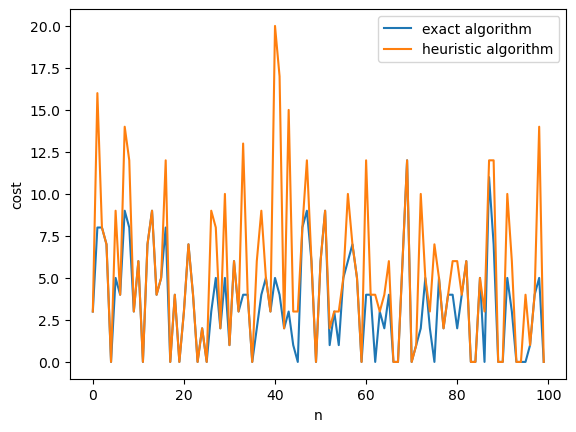

In [26]:
# cost
plt.plot(cost_algorithm1, label='exact algorithm')
plt.plot(cost_heuristic_algorithm, label='heuristic algorithm')
plt.legend()
plt.xlabel("n")
plt.ylabel("cost")
plt.show()

## Loop where the exact and the heuristic algorithm take as input at most 2 random nodes

In [27]:
time_algorithm1 = []
time_heuristic_algorithm = []
set_algorithm1 = []
cost_algorithm1 = []
set_heuristic_algorithm = []
cost_heuristic_algorithm = []
different_output = []

for i in np.arange(100):
    H_erdos_renyi = nx.erdos_renyi_graph(20, 0.1, seed=42, directed=True)

    # transform to ADMG
    test = ADMG()
    test.name = "test"
    edge_list_test = []
    list_of_nodes = list(H_erdos_renyi.nodes)
      
    # transform into list of strings
    list_of_nodes = [str(i) for i in list_of_nodes]
    list_of_edges = list(H_erdos_renyi.edges)

    # transform into list of strings
    list_of_edges = [(str(i), str(j)) for i,j in list_of_edges]
    to_remove = []
    to_add = []
    for i in list_of_edges:
        rand2 = random.randint(0,10) # random number between 0 and 1 which will be used to decide whether edge is bidirected or not 
        if rand2 > 7:
            # bidirected edge
            edge_list_test.append((i[0], i[1], True))
        if rand2 <= 7:
            # directed edge
            edge_list_test.append((i[0], i[1], False))

    for i in list_of_edges:
        if (i[1], i[0], 0) not in list_of_edges:
            edge_list_test.append((i[0], i[1], False)) 
        if (i[1], i[0], 0) in edge_list_test:
            to_remove.append((i[1], i[0], False))
            to_add.append((i[0], i[1], True))

    for r in to_remove:           
        edge_list_test.remove(r)
    for a in to_add:
        edge_list_test.append(a)

    test.add_edges(edge_list_test)

    for i in list_of_nodes: 
        test.add_node(i, random.randint(1, 5))
    
    test_variable = True 
    
    while test_variable: 
        S = random.sample(list_of_nodes, random.randint(1, 2))  # random lenght of random set of nodes 
        start_heuristic_algorithm = timer()
        set2,cost2 = test.minimum_weighted_vertex_cut_splitsetS(S)
        end_heuristic_algorithm = timer()
        if not cost2<0 and cost2 != inf:
            test_variable = False 
            start_algorithm1 = timer()
            set1,cost1 = test.min_cost_intervention_splitsetS(S)
            end_algorithm1 = timer()
            time_algorithm1 = time_algorithm1 + [end_algorithm1-start_algorithm1]
            set_algorithm1 = set_algorithm1 + [set1]
            cost_algorithm1 = cost_algorithm1 + [cost1]
            time_heuristic_algorithm = time_heuristic_algorithm + [end_heuristic_algorithm-start_heuristic_algorithm]
            set_heuristic_algorithm = set_heuristic_algorithm + [set2]
            cost_heuristic_algorithm = cost_heuristic_algorithm + [cost2]

Plot of time (in seconds) and cost both for the exact and the heuristic algorithm 


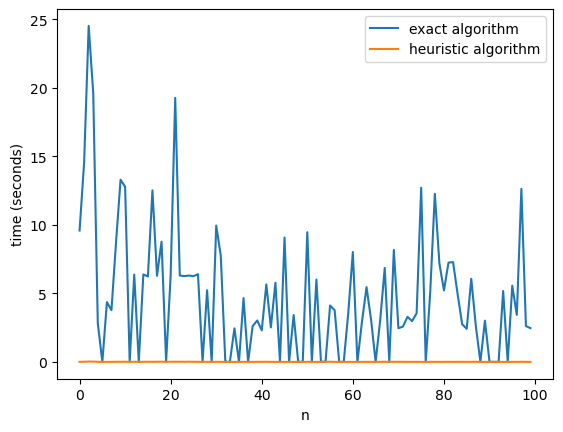

In [28]:
# time 
plt.plot(time_algorithm1, label='exact algorithm')
plt.plot(time_heuristic_algorithm, label='heuristic algorithm')
plt.legend()
plt.xlabel("n")
plt.ylabel("time (seconds)")
plt.show()

In [29]:
time_algorithm1

[9.584129800000028,
 14.552983499999755,
 24.510173099999975,
 19.60469379999995,
 2.820743499999935,
 0.00403199999982462,
 4.361246499999652,
 3.7734292999998615,
 8.705397000000175,
 13.293707600000289,
 12.779791799999657,
 0.01189120000026378,
 6.368780900000274,
 0.013038399999913963,
 6.382829800000309,
 6.238767899999857,
 12.51790899999969,
 6.280237899999975,
 8.771860699999706,
 0.009093600000142033,
 6.326581100000112,
 19.264139500000056,
 6.3030404000001,
 6.262420300000031,
 6.301257999999962,
 6.256029599999692,
 6.396834099999978,
 0.012102900000172667,
 5.227544500000022,
 0.003507700000227487,
 9.943912700000055,
 7.762764499999776,
 0.00891269999965516,
 0.006350499999825843,
 2.447194599999875,
 0.005032099999880302,
 4.653291999999965,
 0.003843400000278052,
 2.611550200000238,
 3.0226118999999017,
 2.3054149000004145,
 5.6528769999999895,
 2.5198261000000457,
 5.775873099999899,
 0.007052700000258483,
 9.075698300000113,
 0.005951399999958085,
 3.420750300000236,

In [30]:
time_heuristic_algorithm

[0.0033716999996613595,
 0.014044600000033824,
 0.029556400000274152,
 0.02137319999974352,
 0.009815400000206864,
 0.0006849999999758438,
 0.004291400000056456,
 0.003616599999986647,
 0.010082900000270456,
 0.010511200000109966,
 0.014333699999951932,
 0.0013958999998067156,
 0.012768200000209617,
 0.0016955000000962173,
 0.009574700000030134,
 0.01156310000033045,
 0.00897690000010698,
 0.010437899999942601,
 0.017915500000071916,
 0.0013879999996788683,
 0.01335719999997309,
 0.013335499999811873,
 0.01348839999991469,
 0.00968810000040321,
 0.015903999999864027,
 0.01064810000025318,
 0.010299900000063644,
 0.001973699999780365,
 0.008426500000041415,
 0.0004432000000633707,
 0.009552800000165007,
 0.003869299999678333,
 0.0009964999999283464,
 0.0008729999999559368,
 0.005617899999833753,
 0.0007005000002209272,
 0.006372700000156328,
 0.0005674000003637047,
 0.004839499999889085,
 0.006741499999861844,
 0.006637200000113808,
 0.012066799999956856,
 0.004460499999822787,
 0.00447

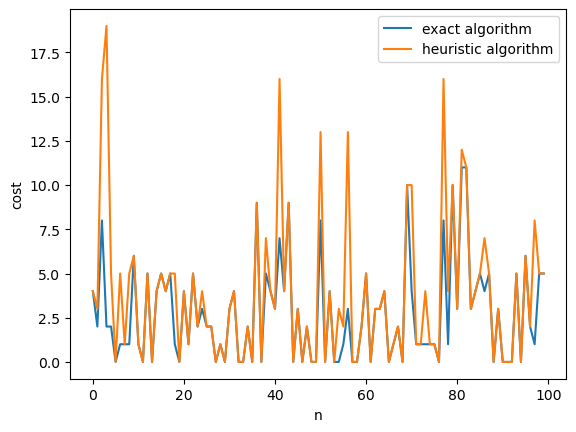

In [31]:
# cost
plt.plot(cost_algorithm1, label='exact algorithm')
plt.plot(cost_heuristic_algorithm, label='heuristic algorithm')
plt.legend()
plt.xlabel("n")
plt.ylabel("cost")
plt.show()